In [395]:
import numpy
import time
import matplotlib.pyplot as plt
import os
import sys 
import nest
import nest.raster_plot
print(nest.version())

nest.ResetKernel()
startbuild = time.time()

NEST nest-2.18.0


In [396]:
def LambertWm1(x):
    return nest.ll_api.sli_func('LambertWm1', float(x))

def ComputePSPNorm(tau_mem, C_mem, tau_syn):
    a = (tau_mem / tau_syn)
    b = (1.0 / tau_syn -1.0 / tau_mem)
    t_max = 1.0 / b * (-LambertWm1(-numpy.exp(-1.0/a)/a) - 1.0 / a)
    return (numpy.exp(1.0) / (tau_syn * (C_mem * b) * 
            ((numpy.exp( -t_max / tau_mem) - numpy.exp(-t_max / tau_syn)) / b - 
            t_max * numpy.exp(-t_max / tau_syn))))

In [397]:
dt = 0.1   # the resolution in ms
simtime = 3000.0  # Simulation time in ms
order = 200
NA = 2 * order  # number of excitatory neurons in pop A
NB = 2 * order  # number of excitatory neurons in pop B
NI = 1 * order  # number of inhibitory neurons
N_neurons = NA + NB + NI   # number of neurons in total
N_rec = order * (2+2+1)  # record from all neurons

In [398]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

In [399]:
tau_m_ex = 20.0  # time constant of membrane potential in ms
tau_m_in = 10.0
C_m_ex = 500.
C_m_in = 200.
theta = -55.0  # membrane threshold potential in mV
t_ref_ex = 2.0
t_ref_in = 1.0
V_membrane = -70.0  # mV 
V_threshold = -50.0  # mV
V_reset = -55.0  # mV 

nr_ports = 4  # number of receptor types (noise-related, AMPA, NMDA, GABA)  
tau_syn_noise = 5.
tau_syn_AMPA = 2.
tau_syn_NMDA = 100.
tau_syn_GABA = 5.
tau_syn = [tau_syn_noise, tau_syn_AMPA, tau_syn_NMDA, tau_syn_GABA]  # [ms]

exc_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": C_m_ex,
    "tau_m": tau_m_ex,
    "t_ref": t_ref_ex, 
    "tau_syn": tau_syn
}
inh_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": C_m_in,
    "tau_m": tau_m_in,
    "t_ref": t_ref_in, 
    "tau_syn": tau_syn
}

nest.SetDefaults("iaf_psc_exp_multisynapse", exc_neuron_params)
pop_A = nest.Create("iaf_psc_exp_multisynapse", NA)
pop_B = nest.Create("iaf_psc_exp_multisynapse", NB)
nest.SetDefaults("iaf_psc_exp_multisynapse", inh_neuron_params)
pop_inh = nest.Create("iaf_psc_exp_multisynapse", NI)

The synaptic currents are normalized such that the amplitude of the PSP is J and each connection weight is calibrated on the specific neurotransmitter time constant (from Brunel 2001)

In [400]:
J = 0.1  # mV -> this means that it takes 200 simultaneous events to drive the spiking activity 

J_unit_noise = ComputePSPNorm(tau_m_ex, C_m_ex, tau_syn_noise)
J_norm_noise = J / J_unit_noise 

J_unit_AMPA = ComputePSPNorm(tau_m_ex, C_m_ex, tau_syn_AMPA)
J_norm_AMPA = J / J_unit_AMPA 

J_norm_NMDA = 0.05  # the weight for the NMDA is set at 0.05, cannot compute J_unit_NMDA since tau_syn_NMDA is greater then tau_m_ex

J_unit_GABA = ComputePSPNorm(tau_m_in, C_m_in, tau_syn_GABA)
J_norm_GABA = J / J_unit_GABA

print("noise: %f" % J_norm_noise)
print("AMPA: %f" % J_norm_AMPA)
print("NMDA: %f" % J_norm_NMDA)  
print("GABA: %f" % J_norm_GABA)

noise: 28.595415
AMPA: 21.560465
NMDA: 0.050000
GABA: 3.745605


Definition of threshold rate, which is the external rate needed to fix the membrane potential around its threshold, the external firing rate and the rate of the poisson generator which is multiplied by the in-degree CE and converted to Hz by multiplication by 1000.

In [401]:
# external rate relative to threshold rate
eta_ex = 2.0 
eta_in = eta_ex

nu_th_noise_ex = (numpy.abs(V_threshold) * C_m_ex) / (J_norm_noise * numpy.exp(1) * tau_m_ex * tau_syn_noise)
nu_ex = eta_ex * nu_th_noise_ex
p_rate_ex = 1000.0 * nu_ex
print("p_rate_ex: %f" % p_rate_ex)
p_rate = p_rate_ex/ 1.3   # the rate for the noise entering in the inhibitory population is reduced 
print("p_rate: %f" % p_rate)
nu_th_noise_in = (numpy.abs(V_threshold) * C_m_in) / (J_norm_noise * numpy.exp(1) * tau_m_in * tau_syn_noise)
nu_in = eta_in * nu_th_noise_in
p_rate_in = 1000.0 * nu_in
print("p_rate_inh: %f" % p_rate_in)

coherence = 0.
p_rate_stim=  p_rate_ex / 24.0   #rate for the input Poisson generator to popA (scaled with respect to the noise)
p_rate_stim_A = (p_rate_stim) * coherence
p_rate_stim_B = (p_rate_stim) * (1-coherence)
print("p_rate_stim: %f" % p_rate_stim)




p_rate_ex: 6432.489928
p_rate: 4948.069175
p_rate_inh: 5145.991942
p_rate_stim: 268.020414


### Building the network
Creation of the nodes using Create. We store the returned handles in variables for later reference. Here the excitatory and inhibitory, as well as the poisson generator and three spike recorders. The spike recorders will later be used to record excitatory and inhibitory spikes. Properties of the nodes are specified via SetDefaults, which expects a dictionary.

In [402]:
#poisson generator for the noise in input to popA and popB
nest.SetDefaults("poisson_generator", {"rate": p_rate_ex})    
PG_noise = nest.Create("poisson_generator")
#poisson generator for the noise in input to popinh
nest.SetDefaults("poisson_generator", {"rate": p_rate_in})   
PG_noise_to_inh = nest.Create("poisson_generator")

# INPUT GENERATOR
nest.SetDefaults("poisson_generator", {"rate": p_rate_stim_A, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popA
PG_input_NMDA_A = nest.Create("poisson_generator")
PG_input_AMPA_A = nest.Create("poisson_generator")
nest.SetDefaults("poisson_generator", {"rate": p_rate_stim_B, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popB
PG_input_NMDA_B = nest.Create("poisson_generator")
PG_input_AMPA_B = nest.Create("poisson_generator")

In [403]:
spikes_a = nest.Create("spike_detector")
spikes_b = nest.Create("spike_detector")
spikes_i = nest.Create("spike_detector")

nest.SetStatus(spikes_a, [{"label": "Exc. pop. A",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_b, [{"label": "Exc. pop. B",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_i, [{"label": "Inh. pop.",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

### Synapse model definition
Definition of a synapse using CopyModel, which expects the model name of a pre-defined synapse, the name of the customary synapse and an optional parameter dictionary. The parameters defined in the dictionary will be the default parameter for the customary synapse. Here we define one synapse for the excitatory and one for the inhibitory connections giving the previously defined weights and equal delays.

In [404]:
#synaptic delays
delay_noise = 0.5
delay_ex_AB_BA = 0.5
delay_ex_reccurent = 0.5
delay_ex_AI_BI = 0.5
delay_in_IA_IB = 0.5
delay_in_recurrent = 0.5

w_plus = 1.7     # a synapse tends to be stronger if 2 cells are selective in the same way
w_minus = 0.80    # a synapse tends to be weaker between cells selective for different inputs

# Definition of synapses
nest.CopyModel("static_synapse", "noise_syn",
               {"weight": J_norm_noise, "delay": delay_noise})
noise_syn = {"model": "noise_syn",
                 "receptor_type": 1}

nest.CopyModel("static_synapse", "excitatory_AMPA_input",
               {"weight": J_norm_AMPA, "delay": delay_noise})
AMPA_input_syn = {"model": "excitatory_AMPA_input",
                 "receptor_type": 2} 
nest.CopyModel("static_synapse", "excitatory_NMDA_input",
               {"weight": J_norm_NMDA, "delay": delay_noise})
NMDA_input_syn = {"model": "excitatory_NMDA_input",
                 "receptor_type": 3}                              

nest.CopyModel("static_synapse", "excitatory_AMPA_AB_BA",
               {"weight": J_norm_AMPA*w_minus, "delay": delay_ex_AB_BA})
AMPA_AB_BA_syn = {"model": "excitatory_AMPA_AB_BA",
                 "receptor_type": 2}
nest.CopyModel("static_synapse", "excitatory_NMDA_AB_BA",
               {"weight": J_norm_NMDA*w_minus, "delay": delay_ex_AB_BA})
NMDA_AB_BA_syn = {"model": "excitatory_NMDA_AB_BA",
                 "receptor_type": 3}               

nest.CopyModel("static_synapse", "excitatory_AMPA_AI_BI",
              {"weight": J_norm_AMPA*w_plus, "delay": delay_ex_AI_BI})
AMPA_AI_BI_syn = {"model": "excitatory_AMPA_AI_BI",
                 "receptor_type": 2}                  
nest.CopyModel("static_synapse", "excitatory_NMDA_AI_BI",
               {"weight": J_norm_NMDA*w_plus, "delay": delay_ex_AI_BI})
NMDA_AI_BI_syn = {"model": "excitatory_NMDA_AI_BI",
                 "receptor_type": 3}  

nest.CopyModel("static_synapse", "inhibitory_IA_IB",
               {"weight": -J_norm_GABA*w_plus, "delay": delay_in_IA_IB})
GABA_IA_IB_syn = {"model": "inhibitory_IA_IB",
                 "receptor_type": 4} 

nest.CopyModel("static_synapse", "excitatory_AMPA_recurrent",
              {"weight": J_norm_AMPA, "delay": delay_ex_reccurent})
AMPA_recurrent_syn = {"model": "excitatory_AMPA_recurrent",
                 "receptor_type": 2}    
nest.CopyModel("static_synapse", "excitatory_NMDA_recurrent",
               {"weight": J_norm_NMDA*w_plus*2.5, "delay": delay_ex_reccurent})
NMDA_recurrent_syn = {"model": "excitatory_NMDA_recurrent",
                 "receptor_type": 3} 
nest.CopyModel("static_synapse", "inhibitory_recurrent",
               {"weight": -J_norm_GABA, "delay": delay_in_recurrent})
GABA_recurrent_syn = {"model": "inhibitory_recurrent",
                 "receptor_type": 4} 

### Connecting Devices
Connecting the previously defined poisson generator to the excitatory and inhibitory neurons using the excitatory synapse. Since the poisson generator is connected to all neurons in the population the default rule (all_to_all) of Connect is used. The synaptic properties are inserted via syn_spec which expects a dictionary when defining multiple variables or a string when simply using a pre-defined synapse.

In [405]:
#EXTERNAL NOISE AND INPUT --> when using a certain type of generator, only one type of syn_spec can be used

nest.Connect(PG_noise, pop_A, syn_spec=noise_syn)
nest.Connect(PG_noise, pop_B, syn_spec=noise_syn)
nest.Connect(PG_noise_to_inh, pop_inh, syn_spec=noise_syn)

nest.Connect(PG_input_AMPA_A, pop_A, syn_spec=AMPA_input_syn)
nest.Connect(PG_input_NMDA_A, pop_A, syn_spec=NMDA_input_syn)

nest.Connect(PG_input_AMPA_B, pop_B, syn_spec=AMPA_input_syn)
nest.Connect(PG_input_NMDA_B, pop_B, syn_spec=NMDA_input_syn)

#Recording devices
nest.Connect(pop_A, spikes_a)
nest.Connect(pop_B, spikes_b)
nest.Connect(pop_inh, spikes_i)

### Connecting Network
Connecting the <b>excitatory population</b>  to all neurons using the pre-defined excitatory synapse. Beforehand, the connection parameter are defined in a dictionary. Here we use the connection rule pairwise_bernoulli, which requires the connection probabilities of having a synapse between two population. Since the synapse specification is reduced to assigning the pre-defined excitatory synapse it suffices to insert a string.

In [406]:
# These lines allow to have different connection probabilities for different types of connections
# connection probability
epsilon_ex_AB_BA = 0.2
epsilon_ex_reccurent = 0.35
epsilon_ex_AI_BI = 0.35
epsilon_in_IA_IB = epsilon_ex_AI_BI
epsilon_in_recurrent = 0.25


conn_params_ex_AB_BA = {'rule': 'pairwise_bernoulli', 'p':epsilon_ex_AB_BA}
conn_params_ex_reccurent = {'rule': 'pairwise_bernoulli', 'p':epsilon_ex_reccurent}
conn_params_ex_AI_BI = {'rule': 'pairwise_bernoulli', 'p':epsilon_ex_AI_BI}
conn_params_in_IA_IB = {'rule': 'pairwise_bernoulli', 'p':epsilon_in_IA_IB}
conn_params_in_recurrent = {'rule': 'pairwise_bernoulli', 'p':epsilon_in_recurrent}


#### Population A

In [407]:

# Recurrent
nest.Connect(pop_A, pop_A, conn_params_ex_reccurent, AMPA_recurrent_syn)
nest.Connect(pop_A, pop_A, conn_params_ex_reccurent, NMDA_recurrent_syn)

# To pop B
nest.Connect(pop_A, pop_B, conn_params_ex_AB_BA, AMPA_AB_BA_syn)
nest.Connect(pop_A, pop_B, conn_params_ex_AB_BA, NMDA_AB_BA_syn)

# To pop inh.
nest.Connect(pop_A, pop_inh, conn_params_ex_AI_BI, AMPA_AI_BI_syn)
nest.Connect(pop_A, pop_inh, conn_params_ex_AI_BI, NMDA_AI_BI_syn)

#### Population B

In [408]:
# Recurrent
nest.Connect(pop_B, pop_B, conn_params_ex_reccurent, AMPA_recurrent_syn)
nest.Connect(pop_B, pop_B, conn_params_ex_reccurent, NMDA_recurrent_syn)

# To pop B
nest.Connect(pop_B, pop_A, conn_params_ex_AB_BA, AMPA_AB_BA_syn)
nest.Connect(pop_B, pop_A, conn_params_ex_AB_BA, NMDA_AB_BA_syn)

# To pop inh.
nest.Connect(pop_B, pop_inh, conn_params_ex_AI_BI, AMPA_AI_BI_syn)
nest.Connect(pop_B, pop_inh, conn_params_ex_AI_BI, NMDA_AI_BI_syn)

#### Inhibitory population

In [409]:
# Recurrent
nest.Connect(pop_inh, pop_inh, conn_params_in_recurrent, GABA_recurrent_syn)

# To pop A
nest.Connect(pop_inh, pop_A, conn_params_in_IA_IB, GABA_IA_IB_syn)

# To pop B
nest.Connect(pop_inh, pop_B, conn_params_in_IA_IB, GABA_IA_IB_syn)


### Simulation of the network.

In [410]:
endbuild = time.time() # Storage of the time point after the buildup of the network in a variable.
print("Simulating")
nest.Simulate(simtime)
endsimulate = time.time() # Storage of the time point after the simulation of the network in a variable.

Simulating


In [411]:
# Reading out the total number of spikes received from the spike recorder connected to 
# the excitatory population and the inhibitory population.
events_ex_a = nest.GetStatus(spikes_a, "n_events")[0]
events_ex_b = nest.GetStatus(spikes_b, "n_events")[0]
events_in = nest.GetStatus(spikes_i, "n_events")[0]

# Calculation of the average firing rate of the excitatory and the inhibitory neurons 
# by dividing the total number of recorded spikes by the number of neurons recorded from and the simulation time. 
# The multiplication by 1000.0 converts the unit 1/ms to 1/s=Hz.
rate_ex_a = events_ex_a / simtime * 1000.0 / NA
rate_ex_b = events_ex_b / simtime * 1000.0 / NB
rate_in = events_in / simtime * 1000.0 / NI


In [412]:
# Establishing the time it took to build and simulate the network by taking the difference of 
# the pre-defined time variables.
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild
# Printing the network properties, firing rates and building times.
print("Excitatory rate A  : %.2f Hz" % rate_ex_a)
print("Excitatory rate B  : %.2f Hz" % rate_ex_b)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

print("Excitatory events A  : %.2f" % events_ex_a)
print("Excitatory events B  : %.2f" % events_ex_b)
print("Inhibitory events : %.2f" % events_in)

Excitatory rate A  : 18.71 Hz
Excitatory rate B  : 7.75 Hz
Inhibitory rate   : 283.46 Hz
Building time     : 1.49 s
Simulation time   : 8.11 s
Excitatory events A  : 22453.00
Excitatory events B  : 9297.00
Inhibitory events : 170074.00


### Plot network activity
Plot a raster of the neurons and a histogram (excitatory:from 1 to 800; inhibitory: from 801 to 1000)

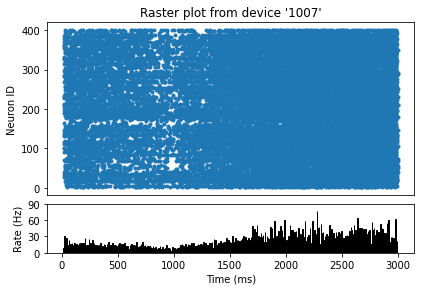

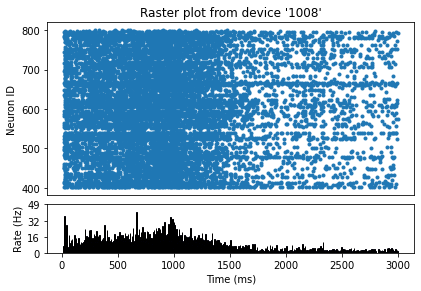

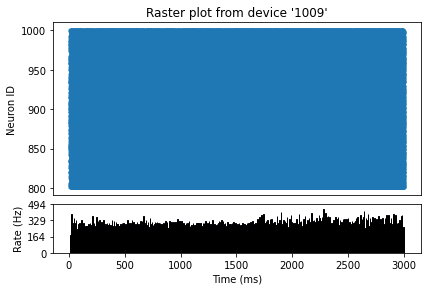

In [413]:
nest.raster_plot.from_device(spikes_a, hist=True)
nest.raster_plot.from_device(spikes_b, hist=True)
nest.raster_plot.from_device(spikes_i, hist=True)
plt.show()

In [414]:
import pandas as pd 

events = nest.GetStatus(spikes_a,"events")
df = pd.DataFrame(events)
senders = pd.DataFrame(df.senders.array)
times = pd.DataFrame(df.times.array)
senders = senders.T
times = times.T
PopA = pd.concat([senders,times],axis = 1)
PopA.columns =['Senders', 'Time']
PopA.to_csv('PopA.csv', index = False, float_format = '%.2f')

In [415]:
import pandas as pd 

events_B = nest.GetStatus(spikes_b,"events")
df_B = pd.DataFrame(events_B)
senders_B = pd.DataFrame(df_B.senders.array)
times_B = pd.DataFrame(df_B.times.array)
senders_B = senders_B.T
times_B = times_B.T
PopB = pd.concat([senders_B,times_B],axis = 1)
PopB.columns =['Senders', 'Time']
PopB.to_csv('PopB.csv', index = False, float_format = '%.2f')

In [416]:
import pandas as pd 

events_i = nest.GetStatus(spikes_i,"events")
df_i = pd.DataFrame(events_i)
senders_i = pd.DataFrame(df_i.senders.array)
times_i = pd.DataFrame(df_i.times.array)
senders_i = senders_i.T
times_i = times_i.T
PopI = pd.concat([senders_i,times_i],axis = 1)
PopI.columns =['Senders', 'Time']
PopI.to_csv('PopI.csv', index = False, float_format = '%.2f')

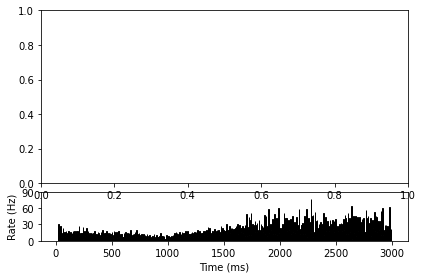

In [417]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_a)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopA_hist = pd.concat([t_bins,heights],axis = 1)
PopA_hist.columns =['time', 'heights']
PopA_hist

PopA_hist.to_csv('PopA_hist.csv', index = False, float_format = '%.2f')

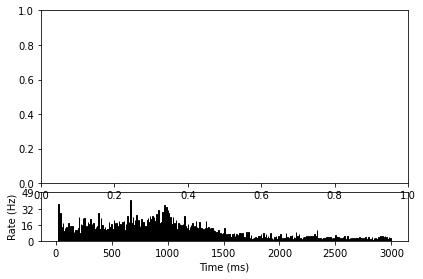

In [418]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_b)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopB_hist = pd.concat([t_bins,heights],axis = 1)
PopB_hist.columns =['time', 'heights']
PopB_hist

PopB_hist.to_csv('PopB_hist.csv', index = False, float_format = '%.2f')

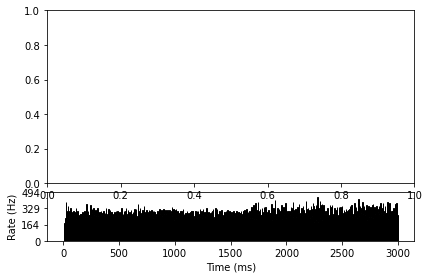

In [419]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_i)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopI_hist = pd.concat([t_bins,heights],axis = 1)
PopI_hist.columns =['time', 'heights']
PopI_hist

PopI_hist.to_csv('PopI_hist.csv', index = False, float_format = '%.2f')